# Self-Driving Car Engineer Nanodegree

## Project: Advanced Lane Finding

***

### Import Packages

In [1]:
# standard library imports
import glob # unused
import math
import os
import re # unused
import shutil

# related third party imports
import cv2
from IPython.display import HTML
import matplotlib.pyplot as plt
import matplotlib.image as mpimg # unused
from moviepy.editor import VideoFileClip
import numpy as np

# output of plotting commands is displayed inline within Jupyter notebook
%matplotlib inline

### Helper functions

In [2]:
def sorted_alphanumeric(data): # unused
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)

### Camera calibration

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


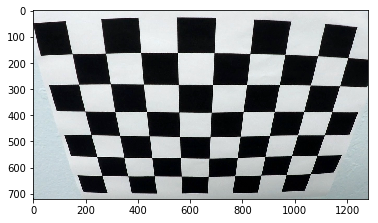

In [3]:
image = cv2.imread('camera_cal/calibration2.jpg')

print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)

In [4]:
# prepare object points
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(7,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = os.listdir('camera_cal')

# Prepare output directory
if not os.path.exists('output_images/camera_cal/corners_found'):
            os.makedirs('output_images/camera_cal/corners_found')
        
# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(f'camera_cal/{fname}')
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        
        write_name = f'output_images/camera_cal/corners_found/{fname}'
        cv2.imwrite(write_name, img)
        #cv2.imshow('img', img)
        #cv2.waitKey(500)
cv2.destroyAllWindows()

Text(0.5,1,'Chessboard Corners')

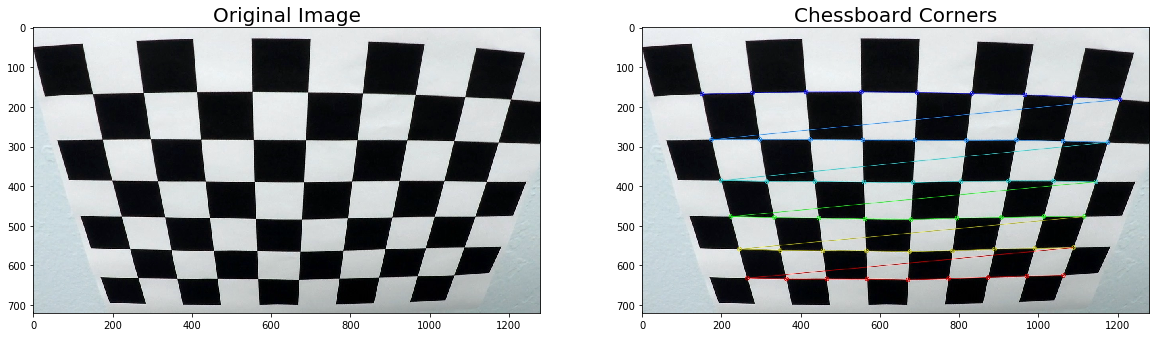

In [5]:
# Visualize chessboard corners
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cv2.imread('camera_cal/calibration2.jpg'))
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(cv2.imread('output_images/camera_cal/corners_found/calibration2.jpg'))
ax2.set_title('Chessboard Corners', fontsize=20)

### Undistortion

In [6]:
img_size = (image.shape[1], image.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

# Prepare output directory
if not os.path.exists('output_images/camera_cal/undistortion'):
            os.makedirs('output_images/camera_cal/undistortion')

for fname in images:
    img = cv2.imread(f'camera_cal/{fname}')
    
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    
    write_name = f'output_images/camera_cal/undistortion/{fname}'
    cv2.imwrite(write_name, dst)

Text(0.5,1,'Undistorted Image')

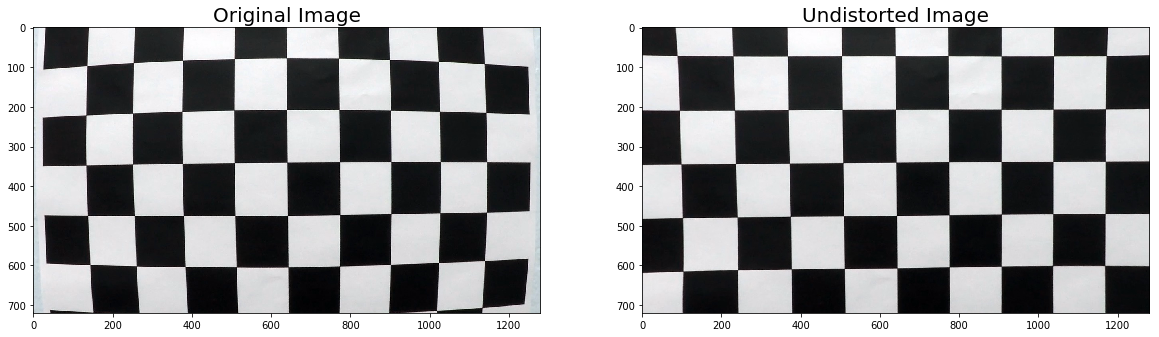

In [7]:
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cv2.imread('camera_cal/calibration1.jpg'))
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(cv2.imread('output_images/camera_cal/undistortion/calibration1.jpg'))
ax2.set_title('Undistorted Image', fontsize=20)

### Undistort test images

In [8]:
# Make a list of test images
test_images = os.listdir('test_images')

# Prepare output directory
if not os.path.exists('output_images/test_images/undistortion'):
            os.makedirs('output_images/test_images/undistortion')

for fname in test_images:
    img = cv2.imread(f'test_images/{fname}')
    
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    write_name = f'output_images/test_images/undistortion/{fname}'
    cv2.imwrite(write_name, undist)

Text(0.5,1,'Undistorted Image')

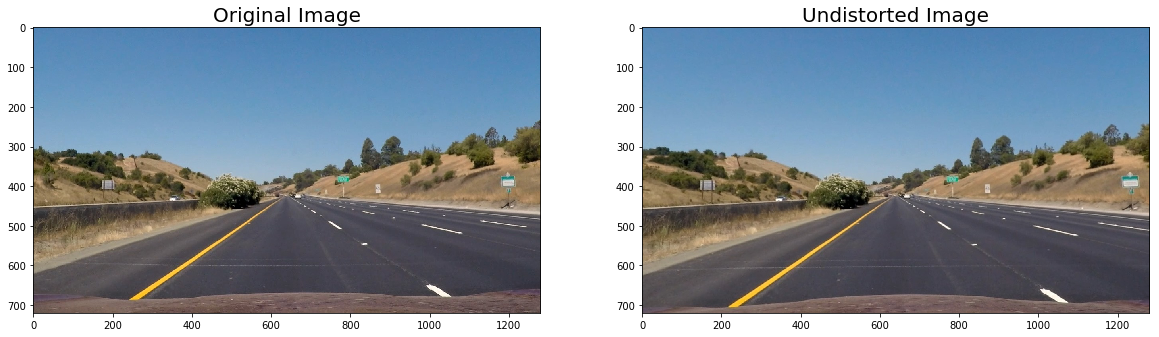

In [9]:
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(mpimg.imread('test_images/straight_lines1.jpg'))
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(mpimg.imread('output_images/test_images/undistortion/straight_lines1.jpg'))
ax2.set_title('Undistorted Image', fontsize=20)

### Draw lines

In [92]:
src_coords = [[190, 720], [1120, 720], [686, 450], [594, 450]]

In [93]:
# Prepare output directory
if not os.path.exists('output_images/test_images/source_points'):
            os.makedirs('output_images/test_images/source_points')

undist_images = os.listdir('output_images/test_images/undistortion')

for fname in undist_images:
    img = cv2.imread(f'output_images/test_images/undistortion/{fname}')
    
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    for idx in range(4):
        cv2.line(line_img, tuple(src_coords[-1+idx]), tuple(src_coords[idx]), (0,0,255), 5)
        
    img = cv2.addWeighted(img, 0.8, line_img, 1, 0)
        
    write_name = f'output_images/test_images/source_points/{fname}'
    cv2.imwrite(write_name, img)

Text(0.5,1,'Undistorted Image with source points drawn')

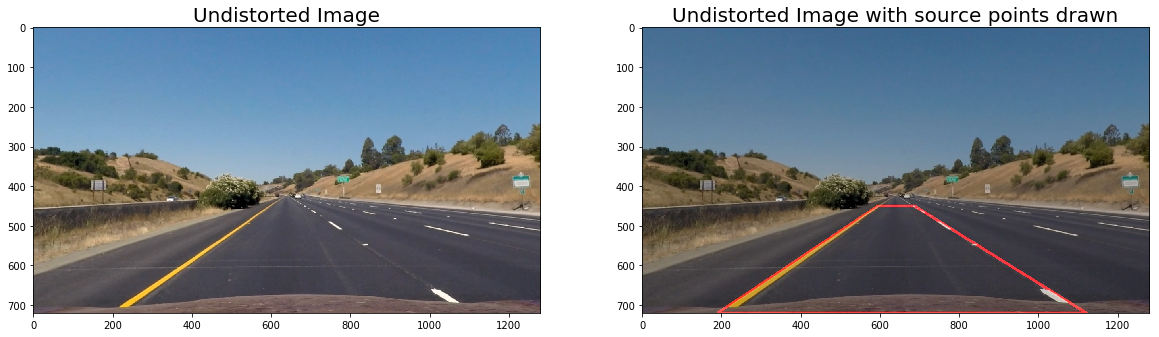

In [94]:
# Visualize lines
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(mpimg.imread('output_images/test_images/undistortion/straight_lines1.jpg'))
ax1.set_title('Undistorted Image', fontsize=20)
ax2.imshow(mpimg.imread('output_images/test_images/source_points/straight_lines1.jpg'))
ax2.set_title('Undistorted Image with source points drawn', fontsize=20)

### Perspective transform

In [95]:
# Prepare output directory
if not os.path.exists('output_images/test_images/warped'):
            os.makedirs('output_images/test_images/warped')

dst_coords =[[300, 720], [950, 720], [950, 0], [300, 0]]

# Define perspective transform function
def warp(img):
    # Define calibration box in source (original) and destination (desired or warped) coordinates
    img_size = (img.shape[1], img.shape[0])
    
    # Four source coordinates
    src = np.float32(src_coords)
    
    # Four desired coordinates
    dst = np.float32(dst_coords)
    
    # Compute perspective transform
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Warp an image using the perspective transform
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped
    
for fname in undist_images:
    img = cv2.imread(f'output_images/test_images/undistortion/{fname}')
    
    write_name = f'output_images/test_images/warped/{fname}'
    cv2.imwrite(write_name, warp(img))
    
unwarp_images = os.listdir('output_images/test_images/warped')

if not os.path.exists('output_images/test_images/dest_points'):
            os.makedirs('output_images/test_images/dest_points')
    
for fname in unwarp_images:
    img = cv2.imread(f'output_images/test_images/warped/{fname}')
    
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    for idx in range(4):
        cv2.line(line_img, tuple(dst_coords[-1+idx]), tuple(dst_coords[idx]), (0,0,255), 5)
        
    img = cv2.addWeighted(img, 0.8, line_img, 1, 0)
    
    write_name = f'output_images/test_images/dest_points/{fname}'
    cv2.imwrite(write_name, img)

Text(0.5,1,'Warped result with destination points drawn')

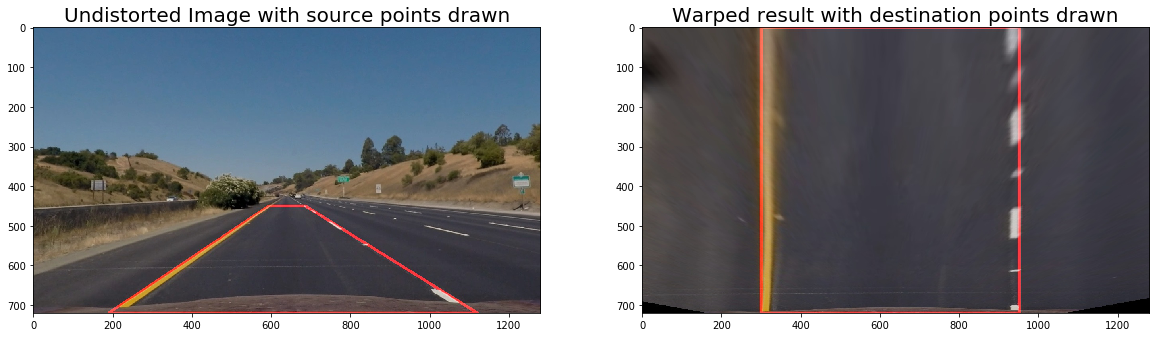

In [96]:
# Visualize perspective transform
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(mpimg.imread('output_images/test_images/source_points/straight_lines1.jpg'))
ax1.set_title('Undistorted Image with source points drawn', fontsize=20)
ax2.imshow(mpimg.imread('output_images/test_images/dest_points/straight_lines1.jpg'))
ax2.set_title('Warped result with destination points drawn', fontsize=20)

### Applying Sobel Operator

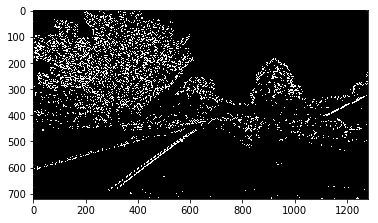

In [121]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output


if not os.path.exists('output_images/test_images/sobel'):
            os.makedirs('output_images/test_images/sobel')

for fname in test_images:
    img = cv2.imread(f'test_images/{fname}')
    
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(20, 50))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=5, thresh=(20, 50))
    mag_binary = mag_thresh(img, sobel_kernel=9, mag_thresh=(30, 100))
    dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    write_name = f'output_images/test_images/sobel/{fname}'
    cv2.imwrite(write_name, combined*255)
    plt.imshow(combined, cmap='gray')